## Overborrowing and Systemic Externalities in the Business Cycle, Bianchi (2011)  

## by Marco Piña

## I. Preliminaries

### Load libraries

In [2]:

using Distributions
using Interpolations #interpolations
using Optim          #optimize
using Roots          #find roots
using ProgressMeter  #to show progress
using LinearAlgebra  #norm function (compute norm of a matrix)
using JLD            #to save and load results
using Plots          #plots
using LaTeXStrings   #to write LaTeX in legends
using QuantEcon      #stationary distributions
using StatsPlots     #kernel density

#Load stochastic structure
include("Bianchi2011_stochastic.jl")
include("aux_funcs.jl")

#Parameters
r  = 0.04             #interest rate
σ  = 2                #risk aversion
η  = 1/0.83-1         #elasticity of substitution
ω  = 0.31             #weight on tradables
β  = 0.91             #discount factor
κ  = 0.32
n  = 4                #nodes
ny = n*n

#grid for b
b_min     = -1.1
b_max     =  0.0
nb        =  500
b_grid    = collect(range(b_min,b_max, length=nb))

#grid for y
YN = repeat(yN_grid,1,nb)
YT = repeat(yT_grid,1,nb)
B  = repeat(b_grid,1, ny)'

#initial values (matrices)
bp = repeat(b_grid,1,ny)'
cT = ones(ny,nb)
pN = ones(ny,nb)
μ  = zeros(ny,nb)
Eμ = zeros(ny,nb)

#Marginal utility
mgu(ct,yn)=( ω*ct^(-η) + (1-ω)*yn^(-η) )^(σ/η-1/η-1) * ω * ct^(-η-1);

mgu (generic function with 1 method)

## II. Competitive Equilibrium Problem

In [3]:
updt    = 0.2  ; #Updating rule: Must be slow, important!
n_iter  = 5000  ;
counter = 0    ;
tol     = 1e-8 ;
show_every= 30 ;

while counter < n_iter
    global updt,counter,n_iter, μ_in ,Eμ,cT,bp,pN,cT_bind,bp_bind

    #save old values
    bp_old = copy(bp)
    cT_old = copy(cT)
    pN_old = copy(pN)

    #Next binding values
    bp_bind = -κ.*(pN.*YN+YT)
    cT_bind = (1+r).*B .+ YT .- bp_bind

    #marginal utility
    λ = ( ω.*cT.^(-η) .+ (1-ω).*YN.^(-η) ).^(σ/η-1/η-1) .* ω .* cT.^(-η-1)

    #Expected marginal utility
    for i in 1:nb
        for j in 1:ny
            Eμ[j,i] = β*(1+r)*T[j,:]'*interp1(b_grid,λ,bp[j,i])
        end
    end

    #Compute Euler's residual assuming that constraint binds
    λ_bind = ( ω.*cT_bind.^(-η) .+ (1-ω).*YN.^(-η) ).^(σ/η-1/η-1) .* ω .* cT_bind.^(-η-1)
    μ      = 1 .- Eμ./λ_bind

    #system of equations
    for i in 1:nb
        for j in 1:ny
            if μ[j,i] > tol #then constraint binds
                bp[j,i] = copy(bp_bind[j,i])
                cT[j,i] = copy(cT_bind[j,i])
            else 
                u(cc) =( ω*cc^(-η) + (1-ω)*YN[j,i]^(-η) )^(σ/η-1/η-1) * ω * cc^(-η-1) .- Eμ[j,i]
                cT[j,i] = fzero( u , 0.1 ) ; μ[j,i] = u(cT[j,i])  # (check μ ≥ 0)
                bp[j,i] = B[j,i]*(1+r) + YT[j,i] - cT[j,i]
            end
        end
    end
    pN = (1-ω)/ω .* (cT./YN).^(1+η)

    #=check collateral constraint
    bp[ bp .< -κ*(pN.*YN+YT) ] = (-κ.*(pN.*YN+YT))[  bp .< -κ*(pN.*YN+YT) ]
    cT = ((1+r).*B .+ YT .- bp)
    pN = (1-ω)/ω .* (cT./YN).^(1+η) # =#

    #updating rule
    bp = updt.*bp .+ (1-updt).*bp_old
    cT = updt.*cT .+ (1-updt).*cT_old
    pN = updt.*pN .+ (1-updt).*pN_old

    #convergence criterion
    diff=maximum( [ maximum(abs.(bp_old .- bp)),
                    maximum(abs.(cT_old .- cT)),
                    maximum(abs.(pN_old .- pN))  ] )

    diff2=round(diff,digits=10)

    if sum(counter .==collect(0:show_every:n_iter)) != 0
        println("Diff = $diff2 ; Iter= $counter")
    else
        nothing
    end

    if diff<tol
        println("Convergence reached :D! convergence=$diff2")
        global cT_out=copy(cT)
        global bp_out=copy(bp)
        global pN_out=copy(pN)
        global μ_out=copy(μ)
        break
    elseif counter ≥ n_iter
        println("Failed convergence D:! iteration=$max_iter")
        break
    end
    counter += 1
end


Diff = 0.3698947921 ; Iter= 0
Diff = 0.027062949 ; Iter= 30
Diff = 0.0074908931 ; Iter= 60
Diff = 0.0028037063 ; Iter= 90
Diff = 0.0010528372 ; Iter= 120
Diff = 0.0004585163 ; Iter= 150
Diff = 0.0002006867 ; Iter= 180
Diff = 8.80296e-5 ; Iter= 210
Diff = 3.86503e-5 ; Iter= 240
Diff = 1.6977e-5 ; Iter= 270
Diff = 7.4584e-6 ; Iter= 300
Diff = 3.2769e-6 ; Iter= 330
Diff = 1.4398e-6 ; Iter= 360
Diff = 6.326e-7 ; Iter= 390
Diff = 2.78e-7 ; Iter= 420
Diff = 1.221e-7 ; Iter= 450
Diff = 5.37e-8 ; Iter= 480
Diff = 2.36e-8 ; Iter= 510
Diff = 1.04e-8 ; Iter= 540
Convergence reached :D! convergence=9.8e-9


### Policy function for debt

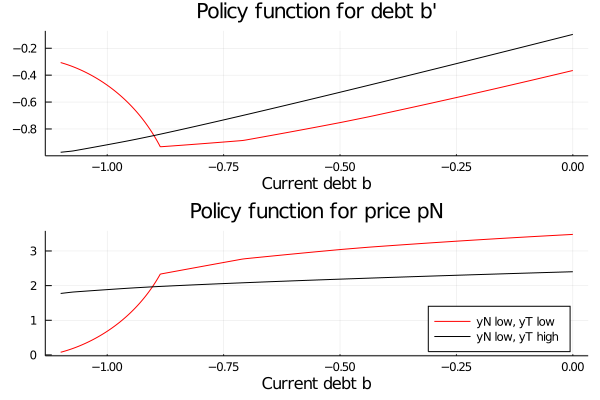

In [4]:
#Policies
plt_b=plot(b_grid,[bp[1,:] bp[end,:] ],
  title="Policy function for debt b'", legend=:none, color= [:red :black],
   xaxis="Current debt b" );

plt_p=plot(b_grid,[pN[1,:] pN[end,:] ],
   label=["yN low, yT low" "yN low, yT high"],
    legend=:bottomright, title="Policy function for price pN", color= [:red :black],
     xaxis="Current debt b" );

plot(plt_b, plt_p, layout=(2,1))

## Checking errors

### Collateral Constraint

In [28]:
sum(bp .< -κ*(pN.*YN .+YT))

364

### Positive $\mu_{t}$

In [9]:
sum(μ .< tol)

7252

In [10]:
### Transversality condition

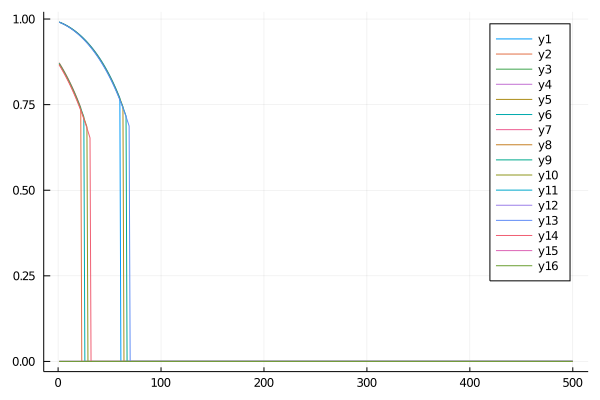

In [11]:
TC= μ.*(bp .< -κ*(pN.*YN .+YT))
plot(TC')

In [ ]:
## III. Social Planner Problem

In [13]:
μsp  = copy(μ)
Eμsp = copy(Eμ) 
cTsp = copy(cT)
bpsp = copy(bp)
pNsp = copy(pN)

#Technical parameters
counter=0
updt= 0.05
tol=1e-8
n_iter=5000
while counter < n_iter
    global updt,counter,n_iter,μsp ,Eμsp,cTsp,bpsp,pNsp,cTsp_bind,bpsp_bind

    #save old values
    bpsp_old = copy(bpsp)
    cTsp_old = copy(cTsp)
    pNsp_old = copy(pNsp)

    #Next binding values
    bpsp_bind = -κ.*(pNsp.*YN+YT)
    cTsp_bind = (1+r).*B .+ YT .- bpsp_bind

    #marginal utility
    λsp = ( ω.*cTsp.^(-η) .+ (1-ω).*YN.^(-η) ).^(σ/η-1/η-1) .* ω .* cTsp.^(-η-1)
    ψ   = κ*(1+η)*pNsp.*(YN./cTsp_bind)
    λsp += μsp.*ψ

    #Expected marginal utility
    for i in 1:nb
        for j in 1:ny
            Eμsp[j,i] = β*(1+r)*T[j,:]'*interp1(b_grid,λsp,bpsp[j,i])
        end
    end

    #Compute Euler's residual assuming that constraint binds
    λsp_bind = ( ω.*cTsp_bind.^(-η) .+ (1-ω).*YN.^(-η) ).^(σ/η-1/η-1) .* ω .* cTsp_bind.^(-η-1) #.+  μsp.*ψ
    μsp = 1 .- Eμsp ./ λsp_bind

    #system of equations
    for i in 1:nb
        for j in 1:ny
            if μsp[j,i] > tol #then constraint binds
                bpsp[j,i] = copy(bpsp_bind[j,i])
                cTsp[j,i] = copy(cTsp_bind[j,i])
            else               #then find optimal consumption
                u(cc)   = mgu(cc,YN[j,i]) - Eμsp[j,i]
                cTsp[j,i] = find_zero( u , 0.1 ) ; μsp[j,i] = u(cTsp[j,i]) # (check μ ≥ 0)
                bpsp[j,i] = B[j,i]*(1+r) + YT[j,i] - cTsp[j,i]
            end
        end
    end
    pNsp = (1-ω)/ω .* (cTsp./YN).^(1+η)

    #= check collateral constraint
    for i in 1:nb
        for j in 1:ny
            if bpsp[j,i] < (-κ*(pNsp.*YN .+YT))[j,i]
                bpsp[j,i] = (-κ*(pNsp.*YN .+YT))[j,i]
                cTsp[j,i] = (1+r).*B[j,i] .+ YT[j,i] .- bpsp[j,i]
                pNsp[j,i] = (1-ω)/ω .* (cTsp[j,i]./YN[j,i]).^(1+η)
            else
                nothing
                # cT[j,i] = (1+r).*B .+ YT .- bpsp[j,i]
                # pN[j,i] = (1-ω)/ω .* (cT[j,i]./YN[j,i]).^(1+η)
            end
        end
    end
    # =#

    #updating rule
    bpsp = updt.*bpsp .+ (1-updt).*bpsp_old
    cTsp = updt.*cTsp .+ (1-updt).*cTsp_old
    pNsp = updt.*pNsp .+ (1-updt).*pNsp_old

    #convergence criterion
    diff=maximum( [ norm(bpsp_old .- bpsp),
                    norm(cTsp_old .- cTsp),
                    norm(pNsp_old .- pNsp)  ] )

    diff2=round(diff,digits=10)

    if sum(counter .==collect(0:show_every:n_iter)) != 0
        println("Diff = $diff2 ; Iter= $counter")
    else
        nothing
    end

    if diff<tol
        println("Convergence reached :D! convergence=$diff2")
        global cTsp_out = copy(cTsp)
        global bpsp_out = copy(bpsp)
        global pNsp_out = copy(pNsp)
        global μsp_out  = copy(μsp)
        break
    elseif counter ≥ n_iter
        println("Failed convergence D:! iteration=$max_iter")
        break
    end
    counter += 1
end


Diff = 0.3443069869 ; Iter= 0
Diff = 0.0168768897 ; Iter= 30
Diff = 0.0079824612 ; Iter= 60
Diff = 0.0040683858 ; Iter= 90
Diff = 0.0018989734 ; Iter= 120
Diff = 0.0008008764 ; Iter= 150
Diff = 0.0003087767 ; Iter= 180
Diff = 0.0001105835 ; Iter= 210
Diff = 3.73185e-5 ; Iter= 240
Diff = 1.20076e-5 ; Iter= 270
Diff = 3.7182e-6 ; Iter= 300
Diff = 1.1162e-6 ; Iter= 330
Diff = 3.267e-7 ; Iter= 360
Diff = 9.37e-8 ; Iter= 390
Diff = 2.64e-8 ; Iter= 420
Convergence reached :D! convergence=9.9e-9


In [9]:
while counter < n_iter
    global updt,counter,n_iter,μsp_in ,Eμsp,cpolsp_in,bpolsp_in,ppolsp_in,cpolsp_bind,bpolsp_bind

    #save old values
    bpolsp_out = copy(bpolsp_in)
    cpolsp_out = copy(cpolsp_in)
    ppolsp_out = copy(ppolsp_in)

    #marginal utility
    λsp = mgu.(cpolsp_in,YN)
    ψ   = κ*(1+η)*ppolsp_in.*(YN./cpolsp_in)
    λsp += μsp_in.*ψ 

    #Expected marginal utility
    for i in 1:nb
        for j in 1:ny
            Eμsp[j,i] = β*(1+r)*T[j,:]'*interp1(b_grid,λsp,bpolsp_in[j,i])
        end
    end

    #Compute Euler's residual assuming that constraint binds
    for i in 1:nb
        for j in 1:ny
            μsp_in[j,i] = mgu(cpolsp_bind[j,i],YN[j,i]) - Eμsp[j,i]
        end
    end

    #system of equations
    for i in 1:nb
        for j in 1:ny
            if μsp_in[j,i] > 0.0 #then constraint binds
                bpolsp_in[j,i] = copy(bpolsp_bind[j,i])
                cpolsp_in[j,i] = copy(cpolsp_bind[j,i])
            else               #then find optimal consumption
                u(cc)   = mgu(cc,YN[j,i]) - Eμsp[j,i]
                cpolsp_in[j,i] = find_zero( u , 0.1 ) ; μsp_in[j,i] = u(cpolsp_in[j,i]) # (check μ ≥ 0)
                bpolsp_in[j,i] = B[j,i]*(1+r) + YT[j,i] - cpolsp_in[j,i]
            end
        end
    end
    ppolsp_in = (1-ω)/ω .* (cpolsp_in./YN).^(1+η)

    #= check collateral constraint
    cpolsp_in = B + YT - max_by_element!(bpolsp_in,-κ*(ppolsp_in.*YN .+YT))
    ppolsp_in = (1-ω)/ω* (cpolsp_in./YN).^(1+η)
    bpolsp_in = (1+r)*B .+YT -cpolsp_in # =#

    #updating rule
    bpolsp_in = updt.*bpolsp_in .+ (1-updt).*bpolsp_out
    cpolsp_in = updt.*cpolsp_in .+ (1-updt).*cpolsp_out
    ppolsp_in = updt.*ppolsp_in .+ (1-updt).*ppolsp_out

    bpolsp_bind = clamp.(-κ.*(ppolsp_in.*YN+YT), b_min,b_max)
    cpolsp_bind = (1+r).*B .+ YT .- bpolsp_bind

    #convergence criterion
    diff=maximum( [norm(bpolsp_out .- bpolsp_in),
                    norm(cpolsp_out .- cpolsp_in),
                    norm(ppolsp_out .- ppolsp_in)  ] )

    diff2=round(diff,digits=7)

    if sum(counter .==collect(0:show_every:n_iter)) != 0
        println("Diff = $diff2 ; Iter= $counter")
    else
        nothing
    end

    if diff<tol
        println("Convergence reached :D! convergence=$diff2")
        global cpolsp_out = copy(cpolsp_in)
        global bpolsp_out = copy(bpolsp_in)
        global ppolsp_out = copy(ppolsp_in)
        global μsp_out    = copy(μsp_in)
        break
    elseif counter ≥ n_iter
        println("Failed convergence D:! iteration=$max_iter")
        break
    end
    counter += 1
end

Diff = 0.2493177 ; Iter= 0
Diff = 0.0224078 ; Iter= 20
Diff = 0.0117044 ; Iter= 40
Diff = 0.0074961 ; Iter= 60
Diff = 0.0048725 ; Iter= 80
Diff = 0.0030593 ; Iter= 100
Diff = 0.0018342 ; Iter= 120
Diff = 0.0010499 ; Iter= 140
Diff = 0.0005758 ; Iter= 160
Diff = 0.000304 ; Iter= 180
Diff = 0.0001553 ; Iter= 200
Diff = 7.71e-5 ; Iter= 220
Diff = 3.73e-5 ; Iter= 240
Diff = 1.77e-5 ; Iter= 260
Diff = 8.2e-6 ; Iter= 280
Diff = 3.8e-6 ; Iter= 300
Diff = 1.7e-6 ; Iter= 320
Convergence reached :D! convergence=1.0e-6


### Policy function for debt

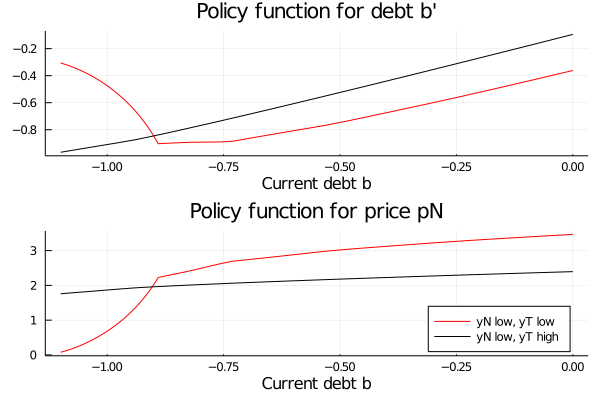

In [14]:
plt_bsp=plot(b_grid,[bpsp_out[1,:] bpsp_out[end,:] ],
  title="Policy function for debt b'", legend=:none, color= [:red :black],
   xaxis="Current debt b" );

plt_psp=plot(b_grid,[pNsp_out[1,:] pNsp_out[end,:] ],
   label=["yN low, yT low" "yN low, yT high"],
    legend=:bottomright, title="Policy function for price pN", color= [:red :black],
     xaxis="Current debt b" );

plot(plt_bsp, plt_psp, layout=(2,1) )

## Checking errors

### Collateral Constraint

In [29]:
sum(bpsp .< -κ*(pNsp.*YN .+YT))

280

### Positive $\mu_t$

In [30]:
sum(μsp .< tol)

7273

### Transversality Condition

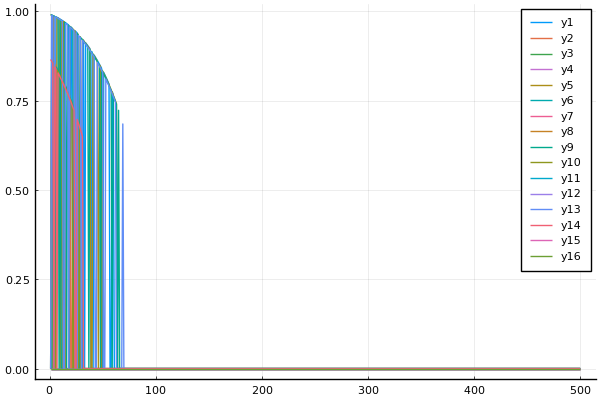

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator


In [31]:
TCsp=μsp.*(bpsp .< -κ*(pNsp.*YN .+YT))
plot(TCsp')

## IV. Simulations

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


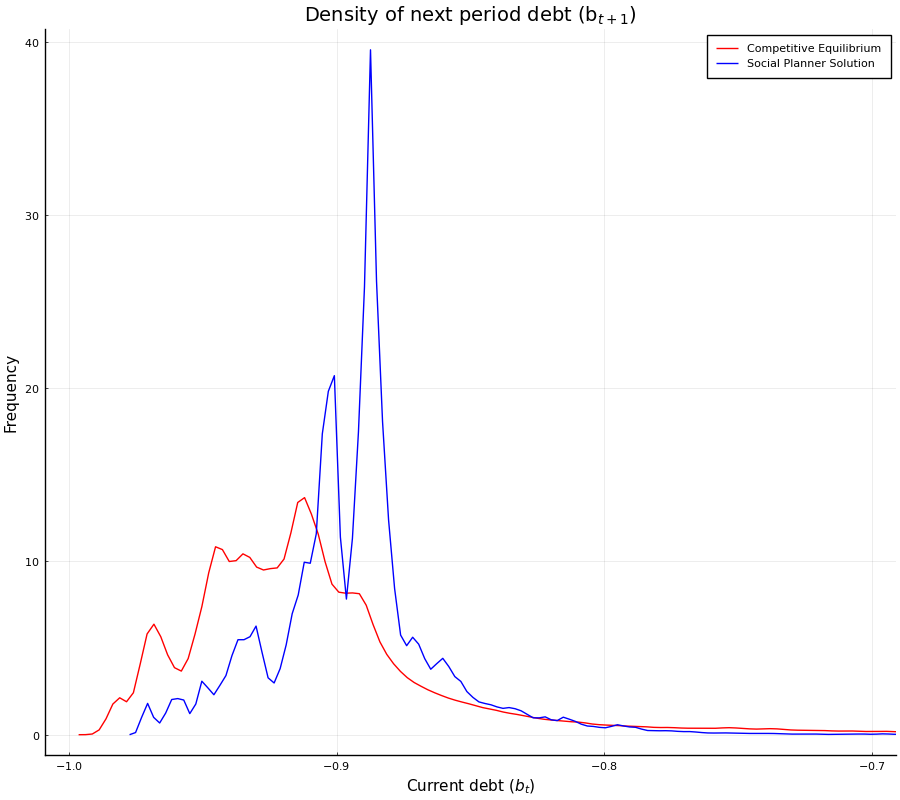

sys:1: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
sys:1: UserWarning: FixedFormatter should only be used together with FixedLocator


In [33]:
pyplot(size=(900,800))
n_sims=800_000
bp_sim, bpsp_sim =Simulate!(n_sims,bp_out,bpsp_out);
b_den=density([bp_sim, bpsp_sim], yaxis= "Frequency",xaxis=(L"Current debt ($b_t$)" ,[-1 ,-0.7]),color=[:red :blue],
        label=["Competitive Equilibrium" "Social Planner Solution"],
        title= L"Density of next period debt (b$_{t+1}$)")

#cd(dirname(@__FILE__))
#savefig(b_den, "./b_density.pdf")

## Appendix: Auxiliary Functions

### Interpolation

In [16]:

function interp1(x::Vector{Float64},
                y::AbstractArray{Float64},
                query::Float64)
    @assert length(x) == size(y,2) || length(x) == size(y,1)

    vector= zeros(size(y,1))
    scalar= 0.0
    if ndims(y)==2
        for i in 1:size(y,1)
            y_intp=extrapolate( interpolate((x,), y[i,:],
                        Gridded(Linear())),Interpolations.Line() )
            vector[i]= y_intp(query)
        end
        return vector
    elseif ndims(y)==1
        y_intp=extrapolate( interpolate((x,), y,
                Gridded(Linear())),Interpolations.Line() )
        scalar = y_intp(query)
        return scalar
    end
end;

### Simulations

In [17]:
function mc_sample_path(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # square required
    N = size(P)[1] # should be square

    # create vector of discrete RVs for each row
    dists = [Categorical(P[i, :]) for i in 1:N]

    # setup the simulation
    X = fill(0, sample_size) # allocate memory, or zeros(Int64, sample_size)
    X[1] = init # set the initial state

    for t in 2:sample_size
        dist = dists[X[t-1]] # get discrete RV from last state's transition distribution
        X[t] = rand(dist) # draw new value
    end
    return X
end

function Simulate!(n_sims,bp,bpsp;cut=Int(floor(n_sims*0.2)))
    y_shock = mc_sample_path(T;sample_size = n_sims+cut)#Simulations
    #preallocations
    bp_sim   = zeros(length(y_shock))
    bpsp_sim = zeros(length(y_shock))

    @showprogress for i in 2:length(y_shock)
        #Simulate y-shocks
        YT_sim=YT[y_shock[i]]
        YN_sim=YN[y_shock[i]]

        #Competitive Equilibrium Simulations
        bp_sim[i]   = interp1(b_grid, bp[y_shock[i],:]  , bp_sim[i-1]   )

#       #Social Planner Simulations
        bpsp_sim[i] = interp1(b_grid, bpsp[y_shock[i],:], bpsp_sim[i-1] )

    end
    return bp_sim[cut:end], bpsp_sim[cut:end]
end